In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging (1)
import core
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from model import create_model, create_dscnn_model, make_esp32_keyword_model

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
sample_rate = 16000
clip_duration_ms = 1000
window_size_ms = 30.0
window_stride_ms = 20.0
feature_bin_count = 40
preprocess = 'mfcc'

BATCH_SIZE = 64

def make_spec_ds(ds):
    return (
        ds
        .unbatch()  # process one sample at a time
        .map(
            lambda audio, label: (
                core.wav_to_features(
                    sample_rate,
                    clip_duration_ms,
                    window_size_ms,
                    window_stride_ms,
                    feature_bin_count,
                    preprocess,         
                    input_audio=audio
                ),
                label
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )   
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="data/speech_commands/train",
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="data/speech_commands/test",
    batch_size=64,
    validation_split=0.0,
    seed=0,    
    output_sequence_length=16000
)

label_names = np.array(train_ds.class_names)
print("Label names:", label_names)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Found 16586 files belonging to 4 classes.
Using 13269 files for training.
Using 3317 files for validation.


I0000 00:00:1765314808.064127   91839 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4065 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 2360 files belonging to 4 classes.


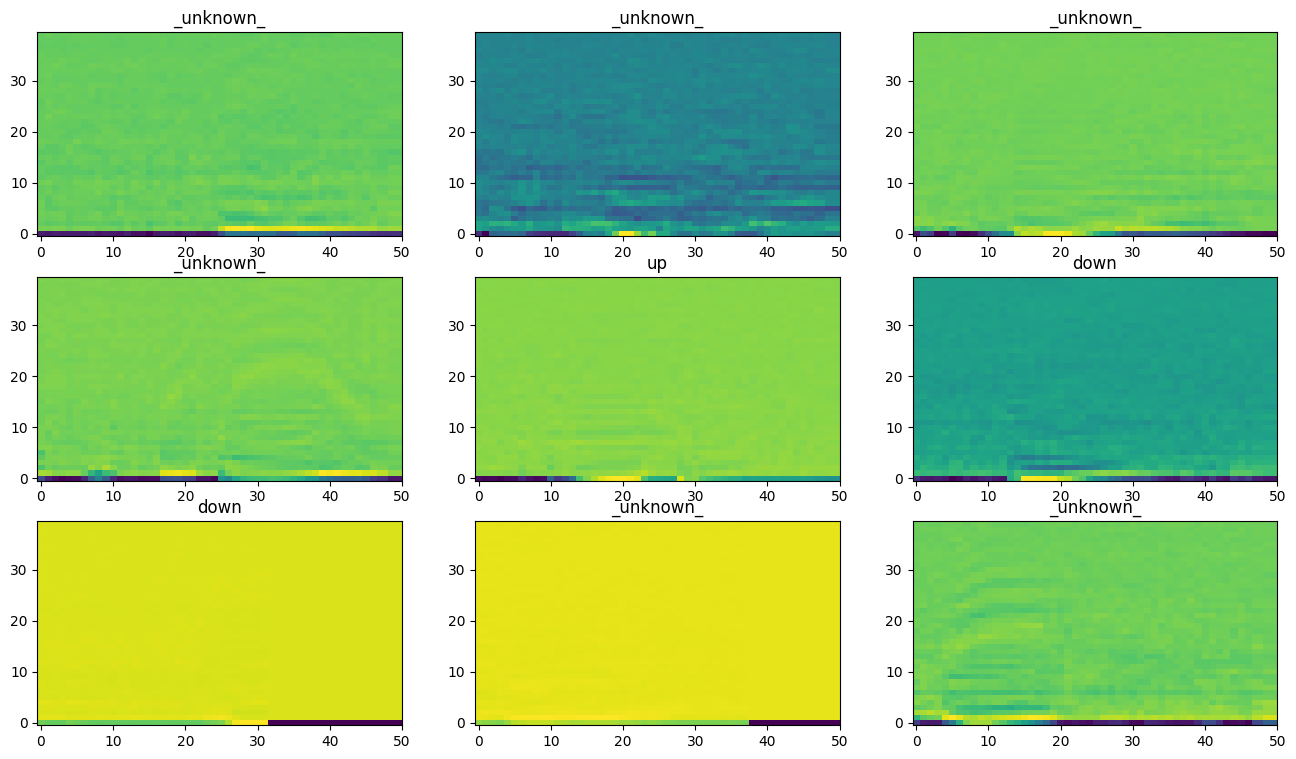

In [4]:
def plot_spectrogram(spectrogram, ax, preprocess=preprocess):
	if len(spectrogram.shape) > 2:
		assert len(spectrogram.shape) == 3
		spectrogram = np.squeeze(spectrogram, axis=-1)
	# Convert the frequencies to log scale and transpose, so that the time is
	# represented on the x-axis (columns).
	# Add an epsilon to avoid taking a log of zero.
	if preprocess == 'mfcc':
		log_spec = spectrogram.T
	else:
		log_spec = np.log(spectrogram.T + np.finfo(float).eps)
	height = log_spec.shape[0]
	width = log_spec.shape[1]
	X = np.linspace(0, width, num=width, dtype=int)
	Y = range(height)
	ax.pcolormesh(X, Y, log_spec)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.show()

In [5]:
input_shape = example_spectrograms.shape[1:]  # (49,40,1)
num_labels = len(label_names)

norm_layer = tf.keras.layers.Normalization()
# Adapt normalization layer
norm_layer.adapt(
    train_spectrogram_ds.map(lambda spec, label: tf.cast(spec, tf.float32))
)

#model = create_dscnn_model(input_shape, num_labels)
model = make_esp32_keyword_model(input_shape, num_labels)
model.summary()

/home/juanignacio/Desktop/UC/S12/Machine_Learning/project_speech_commands/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 49, 40, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 20, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 24, 20, 8)      │            80 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 20, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 12, 10, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 10, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,140 (4.45 KB)

 Trainable params: 1,140 (4.45 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50


I0000 00:00:1765314828.277537   92084 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    208/Unknown 7s 15ms/step - accuracy: 0.5221 - loss: 1.1791

/home/juanignacio/Desktop/UC/S12/Machine_Learning/project_speech_commands/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5266 - loss: 1.0973 - val_accuracy: 0.5333 - val_loss: 1.0474
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5242 - loss: 1.0333 - val_accuracy: 0.5291 - val_loss: 1.0215
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5413 - loss: 0.9744 - val_accuracy: 0.5755 - val_loss: 0.9558
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6124 - loss: 0.8811 - val_accuracy: 0.6141 - val_loss: 0.8647
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6380 - loss: 0.8134 - val_accuracy: 0.6358 - val_loss: 0.8144
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6631 - loss: 0.7697 - val_accuracy: 0.6777 - val_loss: 0.7773
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6862 - loss: 0.7318 - val_accuracy: 0.6916 - val_loss: 0.7641
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6961 - loss: 0.7094 - val_accuracy: 0.6596 - val

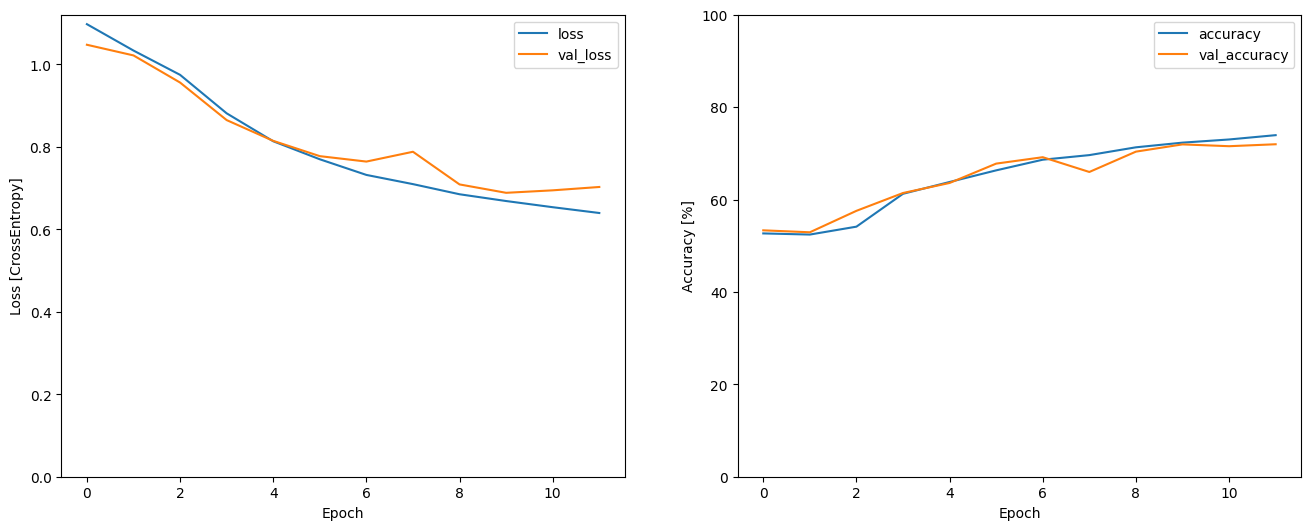

In [7]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

In [8]:
model.evaluate(test_spectrogram_ds, return_dict=True)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6051 - loss: 1.3352


{'accuracy': 0.6050847172737122, 'loss': 1.3352477550506592}

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


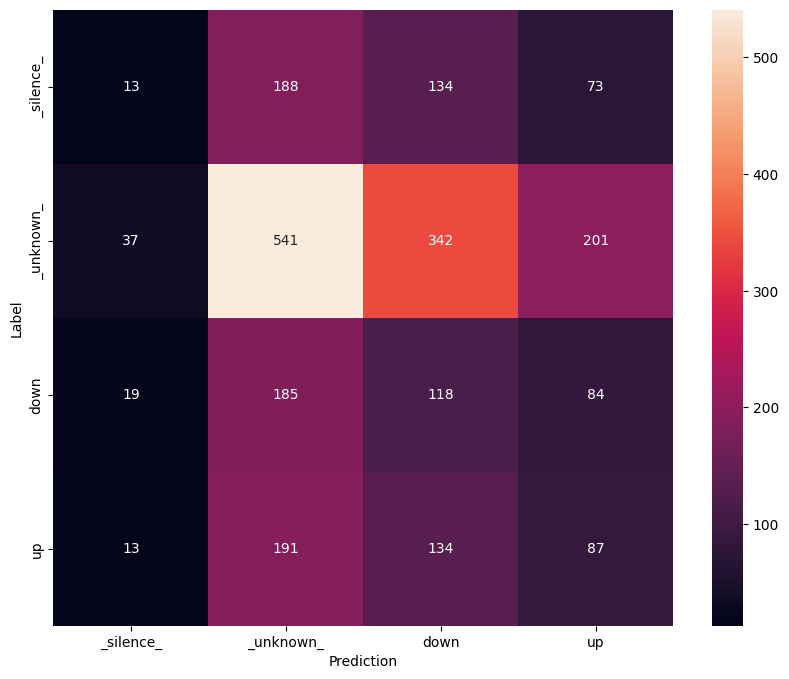

In [9]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

save_dir = 'model_exports'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'model.tflite')
with open(save_path, 'wb') as f:    
    f.write(tflite_model)
print("TFLite model saved to:", save_path)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
quantized_save_path = os.path.join(save_dir, 'model_quant.tflite')
with open(quantized_save_path, 'wb') as f:
    f.write(quantized_tflite_model)
print("Quantized TFLite model saved to:", quantized_save_path)

INFO:tensorflow:Assets written to: /tmp/tmpnc3_1o6u/assets


INFO:tensorflow:Assets written to: /tmp/tmpnc3_1o6u/assets


Saved artifact at '/tmp/tmpnc3_1o6u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 49, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132213273344160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273339056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273342928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273395616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400016:

W0000 00:00:1765314866.142555   91839 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765314866.142567   91839 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1765314866.147953   91839 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Assets written to: /tmp/tmp_rnyk4b6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_rnyk4b6/assets


Saved artifact at '/tmp/tmp_rnyk4b6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 49, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132213273344160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273343104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273339056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273336768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273342928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273395616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132213273400016:

W0000 00:00:1765314866.534798   91839 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765314866.534808   91839 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


In [32]:
for test_sample, test_label in test_spectrogram_ds.take(1):
    print("Test sample shape:", test_sample.shape)

Test sample shape: (64, 49, 40, 1)


In [57]:
def evaluate_tflite(interpreter, test_data, test_label):
    # Get the input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    num_correct = 0
    num_total = 0

    # Iterate over the testing data.
    for i in range(test_data.shape[0]):
        # Get the input data for this example.
        input_data = np.array([test_data[i]], dtype=np.float32)

        # Set the input tensor.
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference.
        interpreter.invoke()

        # Get the output tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Compute the predicted label.
        predicted_label = np.argmax(output_data)

        # Update the results.
        if predicted_label == test_label[i]:
            num_correct += 1
        num_total += 1

    # Reset all variables so it will not pollute other inferences.
    interpreter.reset_all_variables()
    
    # Compute the accuracy.
    accuracy = num_correct / num_total
    
    return accuracy

    
# Load tflite model.
interpreter = tf.lite.Interpreter(model_path="model_exports/speech_commands_model.tflite")
interpreter.allocate_tensors()